### Загрузка необходимых библиотек:

In [1]:
# Основные фреймворки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Настройка визуализации
import matplotlib
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = TEXT_COLOR
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.markersize'] = 15
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

sns.set_style('darkgrid')

------------------

In [3]:
# Загрузка данных
df = pd.read_csv('sensor.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True).drop('Unnamed: 0', axis=1)
df.head(2)

# Временной диапазон 
start = df.index[0]
stop = df.index[-1]

# Выделим в отдельные переменные записи, которые не соответствуют статусу "NORMAL" 
df_broken = df[df.machine_status=='BROKEN']
df_recovering = df[df.machine_status=='RECOVERING']

# Статус машины для визуализации
status = pd.read_csv('y.csv',  index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
status['target'] = 0
status.target.loc[((status.machine_status=='NORMAL') | (status.machine_status=='RECOVERING'))] = 1

In [4]:
X = pd.read_csv('X.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
X_scaled = pd.read_csv('X_scaled.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
pca_res = pd.read_csv('pca_res.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
pca_res1 = pd.read_csv('pca_res1.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)

In [5]:
# Функция для визуализации

def anomaly_visualisation(df, anomaly_columns):
    for sensor in df.columns[:3]:
        _ = plt.figure(figsize=(18,3))
        _ = plt.plot(df[sensor], color='grey', label='Data')
        _ = plt.plot(df.loc[df[anomaly_columns]==1][sensor], linestyle='none', color='r', marker ='.', markersize=2, alpha=.3, label = 'Forest Anomaly')
        _ = plt.plot(df_broken[sensor], linestyle='none', marker='o', color='black', markersize=10, label='BROKEN')
        _ = plt.title(sensor)
        _ = plt.plot(df[sensor].mean()*status.target, linestyle='--', color='orange', label='STATUS')
        plt.xlim(start, stop) 
        plt.tight_layout()
    plt.legend(loc='upper right')   
    plt.show()

In [6]:
# Функция метрик

def metrics_report(test, pred):
    from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
    
    cm = confusion_matrix(test, pred)

    ax = sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'], cmap='RdBu_r')
    ax.set_ylabel('TRUE')
    ax.set_xlabel('PREDICT')
    plt.show()
    
    print(classification_report(test, pred, digits=4))
    print(round(balanced_accuracy_score(test, pred), 4))
    return

Оценка обнаружения аномалий представляет сложную задачу из-за отсутствия размеченной выборки. Поэтому задачу обучения без учителя стараются свести к обучению с учителем, при помощи введения синтетических аномалий.

Так как задача состоит в определении аномалий раньше сбоя (за 24 ча-са), то в качестве размеченных данных создадим синтетические аномалии, так что отклонениями считаются наблюдения за 24 часа до сбоя, отмеченного в признаке «machine_status».

In [7]:
# Синтетические аномалии

from datetime import datetime, timedelta

sint_anomaly = df.machine_status
for day_broken in df_broken.index:
    result_date = day_broken - timedelta(days=1)
    sint_anomaly.loc[result_date:day_broken] = 1
    
sint_anomaly.loc[(sint_anomaly=='BROKEN') | (sint_anomaly=='RECOVERING')] = 1
sint_anomaly.loc[sint_anomaly=='NORMAL'] = 0
sint_anomaly = sint_anomaly.astype('int')
sint_anomaly.value_counts()

0    195756
1     24564
Name: machine_status, dtype: int64

### LOF

In [8]:
%%time
from pyod.models import lof
lof_model1 = lof.LOF(n_neighbors=2000, algorithm='auto', metric='minkowski', p=2, contamination=0.07, n_jobs=-1)
y_pred1 = pd.DataFrame(data=lof_model1.fit_predict(X_scaled.values), columns=['Anomaly'], index=X.index)
y_pred1.value_counts()

Wall time: 7min 17s


Anomaly
0          204897
1           15423
dtype: int64

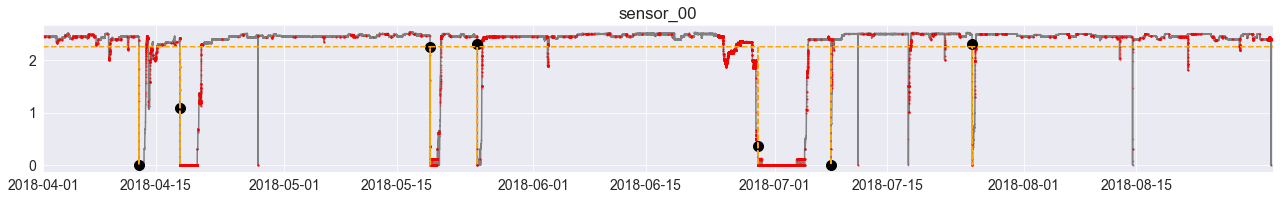

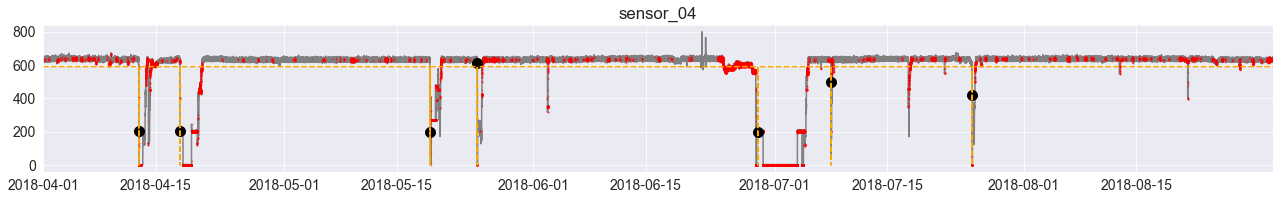

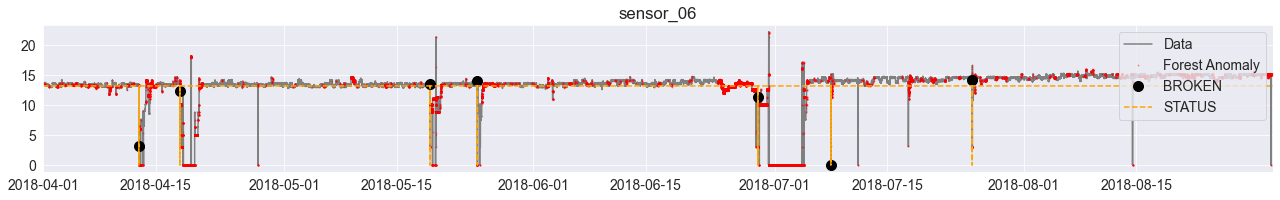

In [33]:
# Визуализация аномалий, обнаруженных при помощи метода LOF

lof_vis = pd.concat([X, y_pred1], axis=1)
anomaly_visualisation(lof_vis, 'Anomaly')

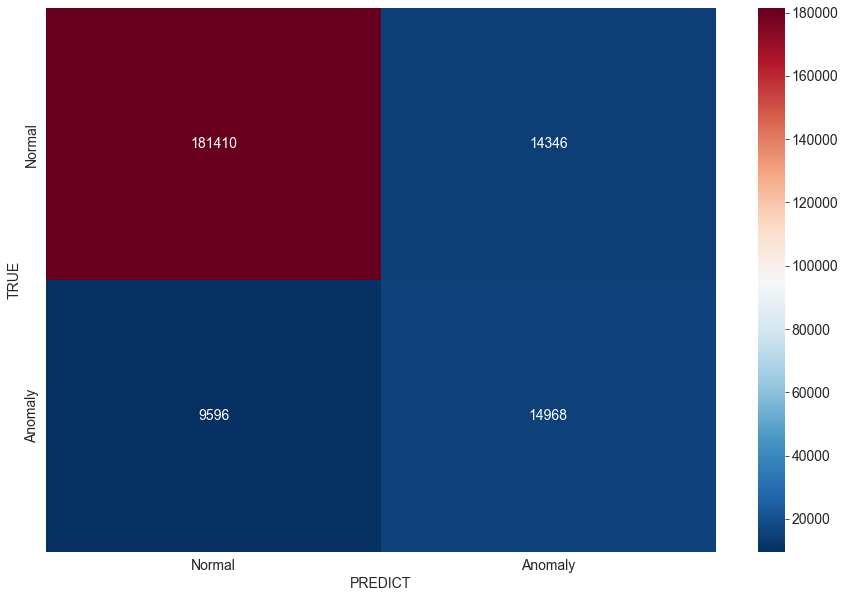

              precision    recall  f1-score   support

           0     0.9498    0.9267    0.9381    195756
           1     0.5106    0.6093    0.5556     24564

    accuracy                         0.8913    220320
   macro avg     0.7302    0.7680    0.7469    220320
weighted avg     0.9008    0.8913    0.8955    220320

0.768


In [34]:
metrics_report(sint_anomaly.values, y_pred1.values)

В задаче предсказания аномалий больший акцент уделяют метрике recall, так как данный показатель показывает, насколько модель ведет себя «уверенно». То есть важнее не пропустить класс 1 (аномалии) и пожертвовать значением FP. Таким образом, необходимо минимизировать ошибку второго рода – FN.